In [4]:
import pandas as pd

data_file = pd.read_csv('../Data/temps.CSV')
print(data_file.head())

print('-------------------------------------------------------------------------')
print(data_file.shape)

   year  month  day  week  temp_2  temp_1  average  actual  friend
0  2016      1    1   Fri      45      45     45.6      45      29
1  2016      1    2   Sat      44      45     45.7      44      61
2  2016      1    3   Sun      45      44     45.8      41      56
3  2016      1    4   Mon      44      41     45.9      40      53
4  2016      1    5  Tues      41      40     46.0      44      41
-------------------------------------------------------------------------
(348, 9)


In [5]:
# 处理时间数据
import datetime

years = data_file['year']
months = data_file['month']
days = data_file['day']

# datetime 格式
dates = [str(year) + '-' + str(month) + '-' + str(day) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

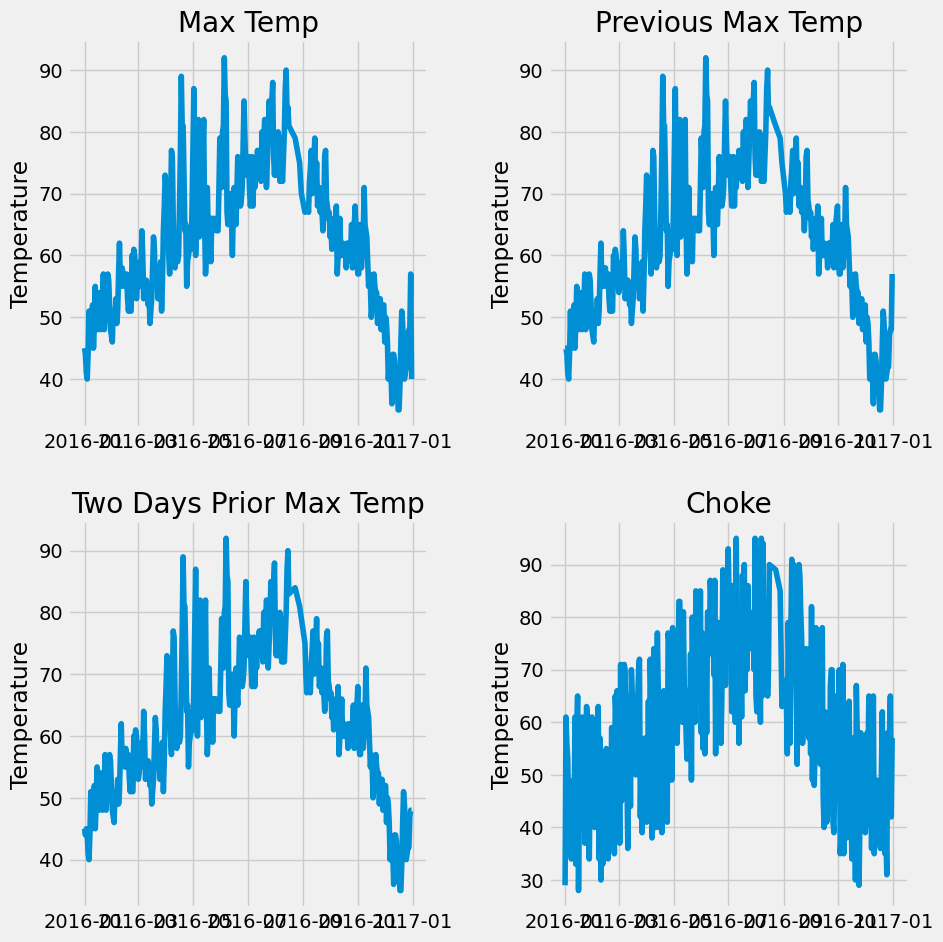

In [6]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1.plot(dates, data_file['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('Temperature')
ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, data_file['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('Temperature')
ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, data_file['temp_2'])
ax3.set_xlabel('')
ax3.set_ylabel('Temperature')
ax3.set_title('Two Days Prior Max Temp')

ax4.plot(dates, data_file['friend'])
ax4.set_xlabel('')
ax4.set_ylabel('Temperature')
ax4.set_title('Choke')

plt.tight_layout(pad=2)

In [7]:
# 独热编码
import pandas as pd

data_file = pd.get_dummies(data_file)

print(data_file.head(5))

   year  month  day  temp_2  temp_1  average  actual  friend  week_Fri  \
0  2016      1    1      45      45     45.6      45      29         1   
1  2016      1    2      44      45     45.7      44      61         0   
2  2016      1    3      45      44     45.8      41      56         0   
3  2016      1    4      44      41     45.9      40      53         0   
4  2016      1    5      41      40     46.0      44      41         0   

   week_Mon  week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed  
0         0         0         0           0          0         0  
1         0         1         0           0          0         0  
2         0         0         1           0          0         0  
3         1         0         0           0          0         0  
4         0         0         0           0          1         0  


In [8]:
# 标签
import numpy as np


labels = np.array(data_file['actual'])

# 从特征中删除标签
features = data_file.drop('actual', axis = 1)

features_list = list(data_file.columns)

print('数据维度：', features.shape)

数据维度： (348, 14)


In [9]:
from sklearn import preprocessing

input_features = preprocessing.StandardScaler().fit_transform(features)

type(input_features)

numpy.ndarray

In [10]:
# 构建网络
import torch

x = torch.tensor(input_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float)

# 参数初始化
weights = torch.randn((14, 128), dtype=torch.float, requires_grad=True)
biases = torch.randn(128, dtype=torch.float, requires_grad=True)
weights_2 = torch.randn((128, 1), dtype=torch.float, requires_grad=True)
biases_2 = torch.randn(1, dtype=torch.float, requires_grad=True)

# 超参数
learning_rate = 0.001

losses = []

for i in range(1000):
    # 计算隐层
    hidden = x.mm(weights) + biases

    # 激活函数
    hidden = torch.relu(hidden)

    # 预测结果
    prrdictions = hidden.mm(weights_2) + biases_2

    # 计算损失
    loss = torch.mean((prrdictions - y) ** 2)
    losses.append(loss.data.numpy())

    # 打印损失值
    if i % 100 ==0:
        print('loss:', loss)

    # 反向传播
    loss.backward()

    # 更新参数
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights_2.data.add_(- learning_rate * weights_2.grad.data)
    biases_2.data.add_(- learning_rate * biases_2.grad.data)

    # 梯度清理
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights_2.grad.data.zero_()
    biases_2.grad.data.zero_()

loss: tensor(10700.0879, grad_fn=<MeanBackward0>)
loss: tensor(156.0207, grad_fn=<MeanBackward0>)
loss: tensor(147.2712, grad_fn=<MeanBackward0>)
loss: tensor(144.6847, grad_fn=<MeanBackward0>)
loss: tensor(143.3425, grad_fn=<MeanBackward0>)
loss: tensor(142.4966, grad_fn=<MeanBackward0>)
loss: tensor(141.8980, grad_fn=<MeanBackward0>)
loss: tensor(141.4456, grad_fn=<MeanBackward0>)
loss: tensor(141.0879, grad_fn=<MeanBackward0>)
loss: tensor(140.8048, grad_fn=<MeanBackward0>)


In [11]:
# 更简单的网络构建

input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [12]:
# 训练模型

losses = []

for i in range(1000):
    batch_loss = []

    # MINI-batch
    for start in range(0, len(input_features), batch_size):
        if start + batch_size <= len(input_features):
            end = start + batch_size
        else:
            end = len(input_features)

        xx = torch.tensor(input_features[start : end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start : end], dtype=torch.float, requires_grad=True)

        predictions = my_nn(xx)
        loss = cost(predictions, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True) # 可重复执行

        optimizer.step() # 更新参数
        batch_loss.append(loss.data.numpy())

    if i % 100 ==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

C:\Users\Lenovo\.conda\envs\Pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Lenovo\.conda\envs\Pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 3949.8008
100 37.835228
200 35.65116
300 35.295303
400 35.133205
500 35.000088
600 34.874268
700 34.74552
800 34.613907
900 34.48171


In [13]:
# 预测结果

x = torch.tensor(input_features, dtype=torch.float)

predict = my_nn(x).data.numpy()